# Latency evaluation

In [1]:
RESULT_DIR = "../out/2025-07-29_17-19-11_librispeech-pc-test-clean_assemblyai"
RESULT_DIR = "../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo"

In [2]:
import os
import sys
sys.path.append("..")

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from src.eval.SampleResult import SampleResult

In [3]:
files = os.listdir(RESULT_DIR)
files = [f for f in files if f.endswith("final.json")]

# get ids from the first part of the filename separated by "_"
file_ids = [f.split("_")[0] for f in files]

samples = [SampleResult.load_by_id(RESULT_DIR, file_id) for file_id in file_ids]

/home/niko/Code/streaming-asr-evaluation/notebooks/../src/eval/SampleResult.py:162: UserWarning: Final MFA file not found: ../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo/mfa/7127-75947-0000/7127-75947-0000.TextGrid
  warnings.warn(f"Final MFA file not found: {final_mfa_path}")
/home/niko/Code/streaming-asr-evaluation/notebooks/../src/eval/SampleResult.py:162: UserWarning: Final MFA file not found: ../out/2025-05-05_13-29-23_librispeech-pc-test-clean_large-v3-turbo/mfa/3575-170457-0000/3575-170457-0000.TextGrid
  warnings.warn(f"Final MFA file not found: {final_mfa_path}")


# Evaluation Parameters

In [4]:
ALIGNMENT_SEQUENCE = "mfa"
TEMPORAL_ALIGNMENT_TOLERANCE = 0.1
ALIGNMENT_WORD_NORMALIZATION = True     # No difference

In [5]:
eval = pd.Series()
eval["num_samples"] = len(samples)
eval["alignment_sequence"] = ALIGNMENT_SEQUENCE
eval["alignment_word_normalization"] = ALIGNMENT_WORD_NORMALIZATION
eval["temporal_alignment_tolerance"] = TEMPORAL_ALIGNMENT_TOLERANCE

In [6]:
for sample in samples:
    try:
        sample.build_alignments(normalize_words=ALIGNMENT_WORD_NORMALIZATION,
                                align_to=ALIGNMENT_SEQUENCE,
                                temporal_tolerance=TEMPORAL_ALIGNMENT_TOLERANCE)
    except Exception as e:
        print(f"Error processing sample {sample.sample_id}: {e}")
        continue

In [7]:
samples_df = pd.DataFrame([{
    "id": sample.sample_id,
    "sample": sample,
    "word_count_final": len(sample.final),
    "word_count_baseline": len(sample.baseline),
    "word_count_transcript": len(sample.transcript),
} for sample in samples])
samples_df

,id,sample,word_count_final,word_count_baseline,word_count_transcript
0,8224-274384-0001,<src.eval.SampleResult.SampleResult object at ...,275,333,333
1,4446-2271-0000,<src.eval.SampleResult.SampleResult object at ...,303,394,395
2,4077-13754-0000,<src.eval.SampleResult.SampleResult object at ...,475,583,585
3,5105-28233-0000,<src.eval.SampleResult.SampleResult object at ...,294,316,317
4,908-31957-0000,<src.eval.SampleResult.SampleResult object at ...,450,466,472
...,...,...,...,...,...
78,2961-961-0000,<src.eval.SampleResult.SampleResult object at ...,488,514,517
79,4970-29095-0000,<src.eval.SampleResult.SampleResult object at ...,643,654,675
80,3575-170457-0000,<src.eval.SampleResult.SampleResult object at ...,1125,1325,1342
81,61-70970-0000,<src.eval.SampleResult.SampleResult object at ...,531,607,628


In [8]:
def total_partial_words(sample: SampleResult) -> int:
    partial_words = [len(partial.result) for partial in sample.partials]
    return sum(partial_words)

def unaligned_partial_words(sample: SampleResult) -> int:
    unalignments = [len(alignements.unalignments) for alignements in sample.alignments]
    return sum(unalignments)

In [9]:
samples_df["unaligned_partial_count"] = samples_df["sample"].apply(unaligned_partial_words)
samples_df["partial_count"] = samples_df["sample"].apply(total_partial_words)

eval["total_partial_count"] = samples_df["partial_count"].sum().item()
eval["unaligned_partial_count"] = samples_df["unaligned_partial_count"].sum().item()

## Word Error Rate

In [10]:
eval["wer"] = np.mean([s.word_error_rate() for s in samples])
eval["wer"]

0.19639879624704215

In [11]:
from src.helper.word_sequence import word_sequence_to_string
print(word_sequence_to_string(samples[0]._alignment_sequence))
print(word_sequence_to_string(samples[0].final))

the scottish generals and commissioners affected great surprise on the appearance of the king and though they paid him all the exterior respect due to his dignity they instantly set a guard upon him under color of protection and made him in reality a prisoner they informed the english parliament of this unexpected incident and assured them that they had entered into no private treaty with the king or hath he given us any gift and the men of israel answered the men of judah and said we have ten parts in the king and we have also more right in david than ye why then did ye despise us that our advice should not be first had in bringing back our king another preacher after reproaching him to his face with his misgovernment ordered this psalm to be sung the king stood up and called for that psalm which begins with these words have mercy lord on me i pray for men would me devour the good natured audience in pity to fallen majesty showed for once greater deference to the king than to the mini

## Word first correct

The word first correct (wfc) is defined as the first correct occurence of a word.

In [12]:
wfc = [s.word_first_corrects() for s in samples]

In [13]:
total_wfc = np.concat(wfc)
wfc_latency = np.array([r["latency"] for r in total_wfc if r is not None])
none_wfc_count = len(total_wfc) - len(wfc_latency)
print("None values in wfc: ", none_wfc_count, f"({none_wfc_count / len(total_wfc) * 100:.2f}%)")
eval["wfc_none_count"] = none_wfc_count

None values in wfc:  796 (1.64%)


In [14]:
print("Min:", np.min(wfc_latency))
print("Max:", np.max(wfc_latency))
print("Mean:", np.mean(wfc_latency))
print("Median:", np.median(wfc_latency))
print("Std:", np.std(wfc_latency))
print("P95:", np.percentile(wfc_latency, 95))
print("P99:", np.percentile(wfc_latency, 99))

eval["wfc_latency_count"] = len(wfc_latency)
eval["wfc_latency_mean"] = np.mean(wfc_latency).item()
eval["wfc_latency_std"] = np.std(wfc_latency).item()
eval["wfc_latency_median"] = np.median(wfc_latency).item()

Min: 0.37162623785436155
Max: 32.498076221048834
Mean: 2.552678695439298
Median: 2.066158089786782
Std: 1.6638782676908364
P95: 5.883404127493498
P99: 9.84970083489046


In [15]:
### DEBUG

for i, s_el in enumerate(wfc):
    for el in s_el:
        if el and el["latency"] > 30:
            sample_id = samples[i].sample_id
            print(f"Sample {sample_id} with huge latency {el}")

Sample 5639-40744-0000 with huge latency {'timestep': 93, 'observation_time': 124.07807622104883, 'latency': 32.498076221048834}


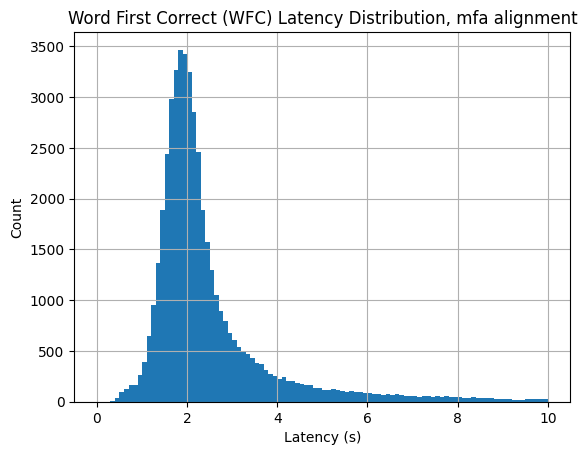

In [16]:
plt.hist(wfc_latency,
         bins=100,
         range=(0, math.ceil(np.percentile(wfc_latency, 99).item())),
         )
plt.xlabel("Latency (s)")
plt.ylabel("Count")
plt.title(f"Word First Correct (WFC) Latency Distribution, {ALIGNMENT_SEQUENCE} alignment")
plt.grid()

## Word first final

The word first final (wff) is defined as the first occurence after which a word will never change to a different prediction.

In [17]:
wff = [s.word_first_finals() for s in samples]

In [18]:
total_wff = np.concat(wff)
wff_latency = np.array([r["latency"] for r in total_wff if r is not None])
none_wff_count = len(total_wff) - len(wff_latency)
print("None values in wff: ", none_wff_count, f"({none_wff_count / len(total_wff) * 100:.2f}%)")
eval["wff_none_count"] = none_wff_count

None values in wff:  796 (1.64%)


In [19]:
print("Min:", np.min(wff_latency))
print("Max:", np.max(wff_latency))
print("Mean:", np.mean(wff_latency))
print("Median:", np.median(wff_latency))
print("Std:", np.std(wff_latency))
print("P95:", np.percentile(wff_latency, 95))
print("P99:", np.percentile(wff_latency, 99))

eval["wff_latency_count"] = len(wff_latency)
eval["wff_latency_mean"] = np.mean(wff_latency).item()
eval["wff_latency_std"] = np.std(wff_latency).item()
eval["wff_latency_median"] = np.median(wff_latency).item()

Min: 0.37162623785436155
Max: 147.36444377034903
Mean: 8.631393475845092
Median: 6.16173594884574
Std: 9.670751033639096
P95: 18.856991888765236
P99: 30.33392829632909


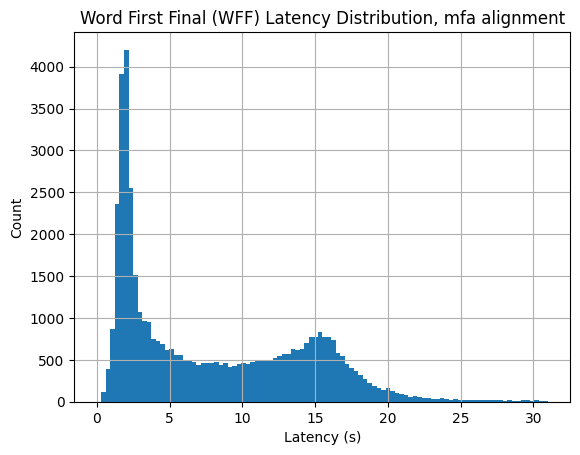

In [20]:
plt.hist(wff_latency, bins=100, range=(math.floor(np.percentile(wff_latency, 1)), math.ceil(np.percentile(wff_latency, 99).item())))
plt.xlabel("Latency (s)")
plt.ylabel("Count")
plt.title(f"Word First Final (WFF) Latency Distribution, {ALIGNMENT_SEQUENCE} alignment")
plt.grid()

In [21]:
eval

num_samples                           83
alignment_sequence                   mfa
alignment_word_normalization        True
temporal_alignment_tolerance         0.1
total_partial_count               964777
unaligned_partial_count             3127
wer                             0.196399
wfc_none_count                       796
wfc_latency_count                  47682
wfc_latency_mean                2.552679
wfc_latency_std                 1.663878
wfc_latency_median              2.066158
wff_none_count                       796
wff_latency_count                  47682
wff_latency_mean                8.631393
wff_latency_std                 9.670751
wff_latency_median              6.161736
dtype: object